## Inference with Syllog and Pyro

This example is adapted from the [Pyro documentation](http://pyro.ai/examples/intro_part_ii.html).

In [20]:
#!cairo install pytorch -c pytorch
#!pip install cairocffi pyro matplotlib

In [21]:
import torch
import pyro
import cairocffi as cairo # need this import/rename for igraph plotting, it can be ommitted if you don't plot
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from lib.syllog_model import SyllogPyroModel # Class that reads Syllog JSON into a Pyro model
from factors.pyro import factors as PyroFactors # Module providing factors from pyro.distributions

### Model construction
Let's start by constructing our model from a Syllog model (see the `icecream` notebook for a detailed breakdown of this step)

In [22]:
with open('data/scale.json', 'r') as jsonfile:
    cyjson=jsonfile.read()

In [23]:
model = SyllogPyroModel.from_cyjson(cyjson)

In [24]:
factor_fns = dict({
    desc['fn']: getattr(PyroFactors, desc['fn']) 
    for desc 
    in model.get_factor_descriptions().values()
})

In [25]:
model.get_evidence_nodes()

['guess', 'weight_var', 'measure_var']

Note that we construct a sampling function here that takes a guess for the weight, 
rather than providing all evidence variables.

In [26]:
def scale(guess):
    evidence = {'guess': guess, 'weight_var': 1., 'measure_var': 0.75}
    return model(evidence, factor_fns)['measurement']

In [27]:
samples = [scale(1.2) for i in range(100)]

(array([2., 0., 0., 0., 0., 2., 0., 0., 1., 3., 2., 2., 1., 1., 1., 3., 1.,
        1., 3., 3., 3., 1., 4., 9., 1., 5., 2., 3., 3., 4., 1., 3., 4., 4.,
        4., 3., 2., 1., 3., 3., 0., 2., 2., 2., 0., 3., 0., 0., 1., 1.]),
 array([-1.6802535 , -1.561944  , -1.4436346 , -1.3253251 , -1.2070158 ,
        -1.0887063 , -0.9703968 , -0.8520874 , -0.7337779 , -0.61546844,
        -0.497159  , -0.37884957, -0.2605401 , -0.14223066, -0.0239212 ,
         0.09438825,  0.2126977 ,  0.33100715,  0.4493166 ,  0.56762606,
         0.6859355 ,  0.80424494,  0.9225544 ,  1.0408639 ,  1.1591733 ,
         1.2774827 ,  1.3957922 ,  1.5141016 ,  1.6324111 ,  1.7507205 ,
         1.86903   ,  1.9873395 ,  2.105649  ,  2.2239583 ,  2.3422678 ,
         2.4605772 ,  2.5788867 ,  2.6971962 ,  2.8155055 ,  2.933815  ,
         3.0521245 ,  3.170434  ,  3.2887435 ,  3.4070528 ,  3.5253623 ,
         3.6436718 ,  3.7619812 ,  3.8802907 ,  3.9986    ,  4.1169095 ,
         4.235219  ], dtype=float32),
 <a li

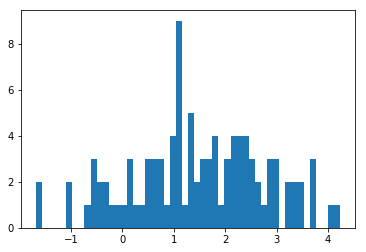

In [28]:
plt.hist(samples, bins=50)

### Inference
We can construct a posterior in the standard Pyro way from our model.

In [29]:
posterior = pyro.infer.Importance(scale, num_samples = 100)

In [30]:
guess = 8.5
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))
print(marginal())

tensor(7.9752)


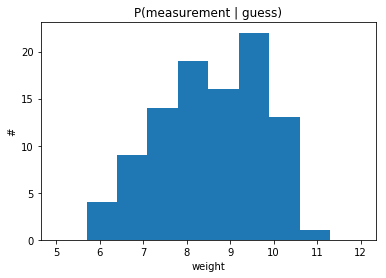

In [31]:
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#");